## Projeto Sprint 10

In [4]:
# Bibliotecas padrão
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler


### Funções de processamento de dados e treinamento do modelo

In [5]:
def load_and_split_data(data):
    data = pd.read_csv(data)
    features = data[["f0", "f1", "f2"]]
    target = data["product"]
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    X_train, X_valid, y_train, y_valid = train_test_split(
        features_scaled, target, test_size=0.25, random_state=12345
    )
    return X_train, X_valid, y_train, y_valid


def train_model(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model


def evaluate_model(model, X_valid, y_valid):
    predictions = model.predict(X_valid)
    sqmse = (np.mean((predictions - y_valid) ** 2)) ** 0.5
    return sqmse, predictions


### Aplicando as funções em nosso conjunto de dados


 Região 0:
REQM: 37.58
Volume médio previsto: 92.59

 Região 1:
REQM: 0.89
Volume médio previsto: 68.73

 Região 2:
REQM: 40.03
Volume médio previsto: 94.97


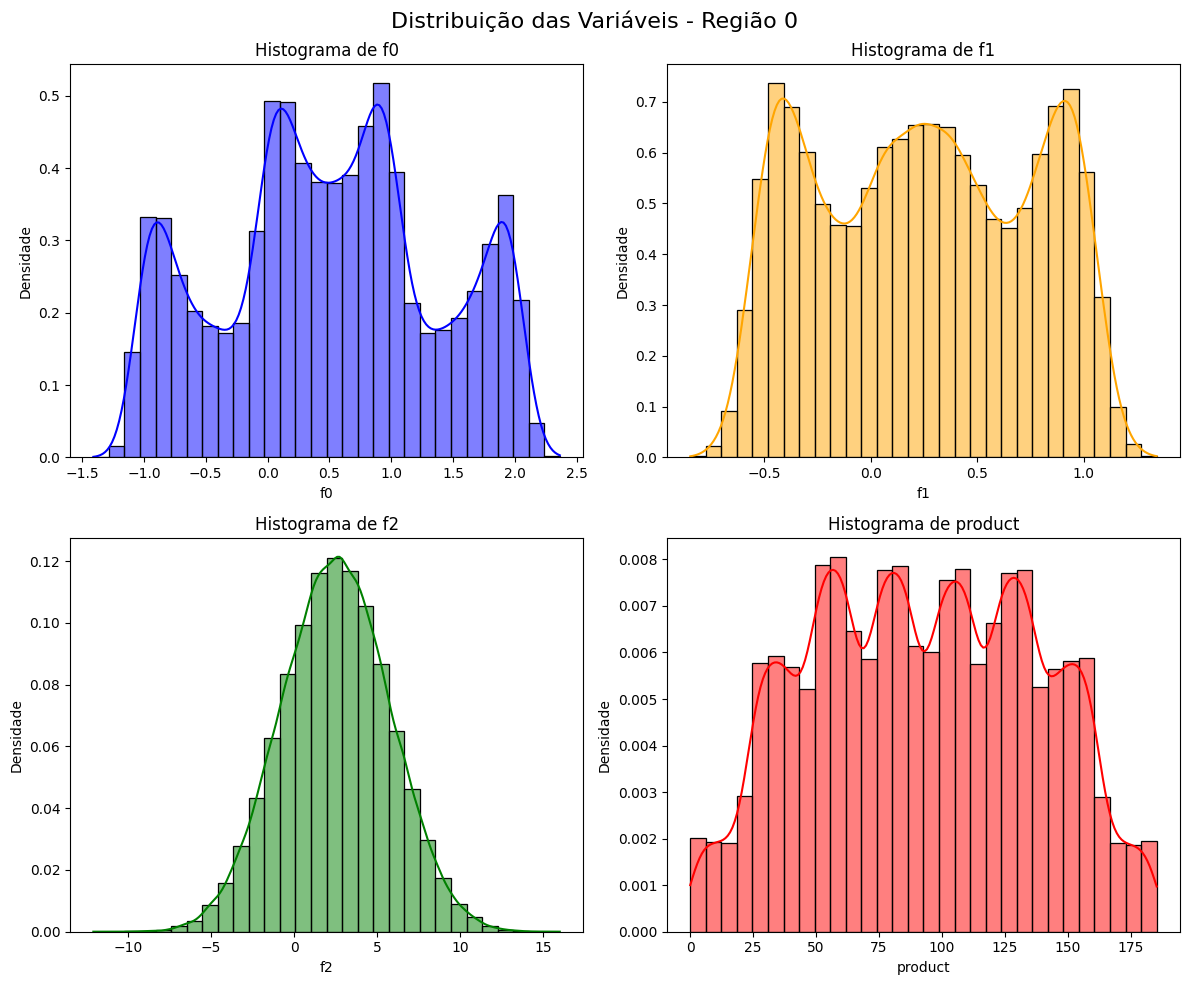

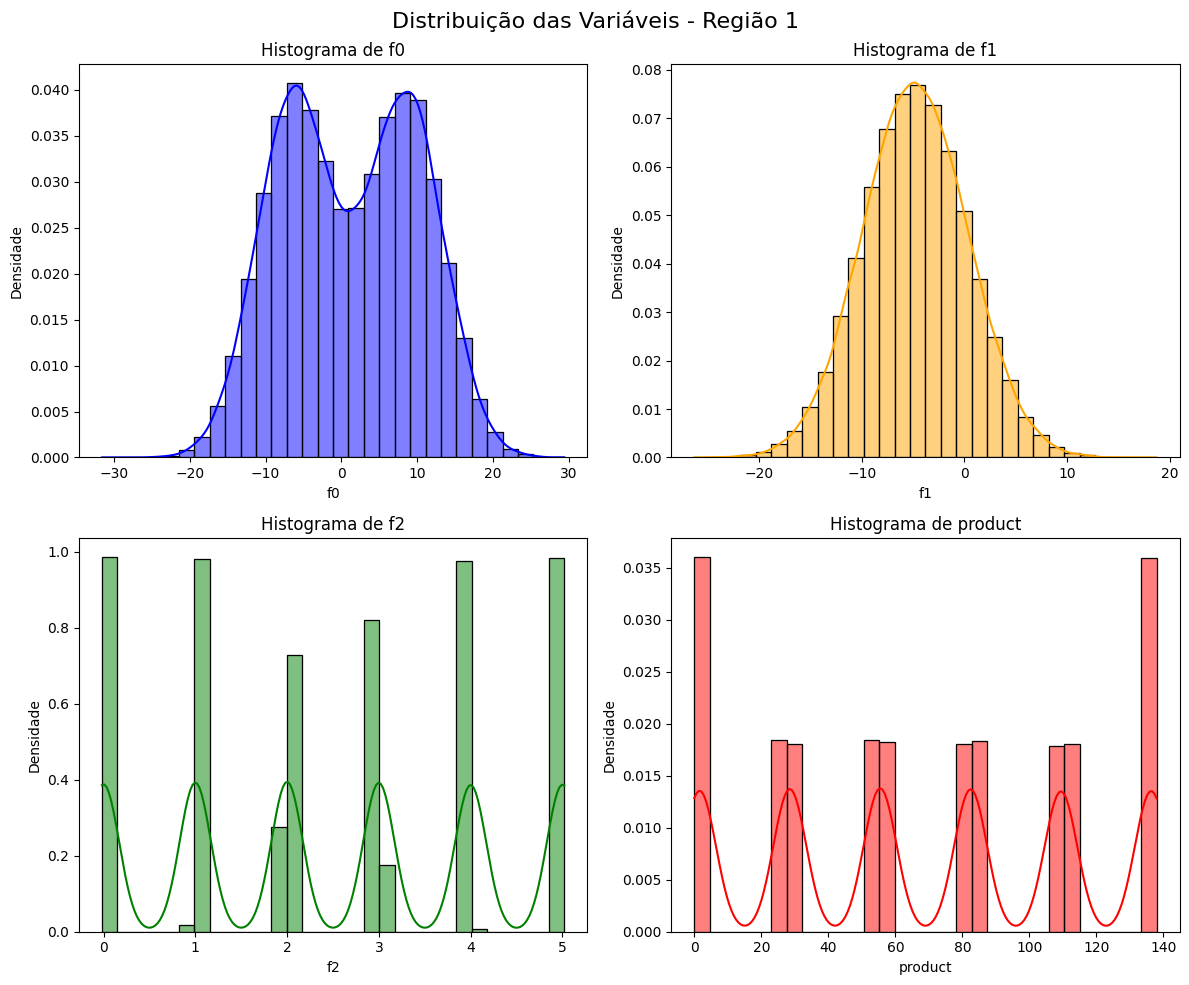

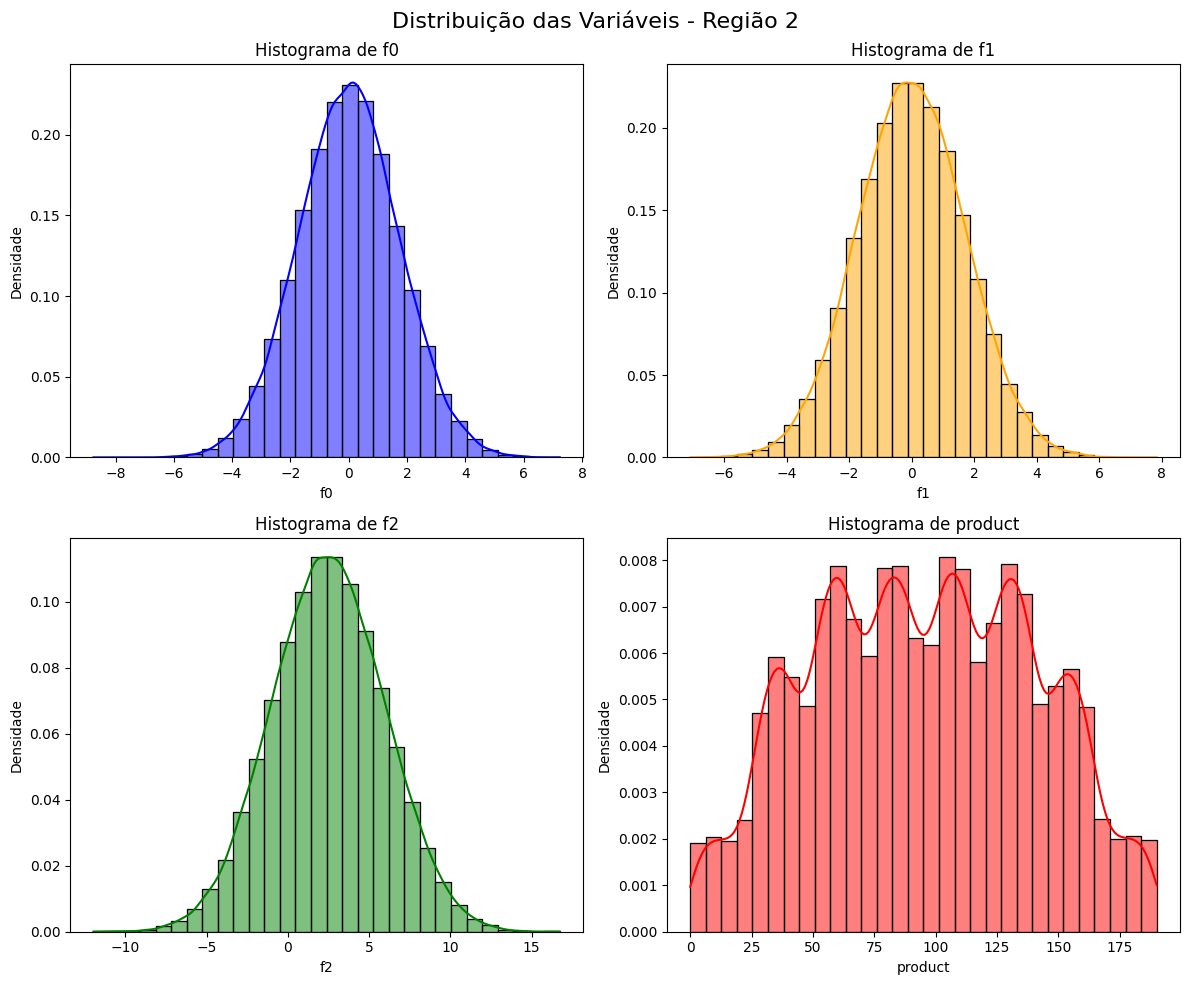

In [6]:
data_1 = "datasets/geo_data_0.csv"
data_2 = "datasets/geo_data_1.csv"
data_3 = "datasets/geo_data_2.csv"

results = {}

for i, data in enumerate([data_1, data_2, data_3]):
    X_train, X_valid, y_train, y_valid = load_and_split_data(data)
    model = train_model(X_train, y_train)
    sqmse, predictions = evaluate_model(model, X_valid, y_valid)

    results[f"region_{i}"] = {
        "model": model,
        "predictions": predictions,
        "y_valid": y_valid,
        "X_valid": X_valid,
    }
    print("\n", f"Região {i}:")
    print(f"REQM: {sqmse:.2f}")
    print(f"Volume médio previsto: {predictions.mean():.2f}")

for i, data_path in enumerate([data_1, data_2, data_3]):
    data = pd.read_csv(data_path)
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f"Distribuição das Variáveis - Região {i}", fontsize=16)

    sns.histplot(
        data["f0"],
        color="blue",
        kde=True,
        stat="density",
        bins=30,
        ax=axes[0, 0],
    )
    axes[0, 0].set_title("Histograma de f0")
    axes[0, 0].set_xlabel("f0")
    axes[0, 0].set_ylabel("Densidade")

    sns.histplot(
        data["f1"],
        color="orange",
        kde=True,
        stat="density",
        bins=30,
        ax=axes[0, 1],
    )
    axes[0, 1].set_title("Histograma de f1")
    axes[0, 1].set_xlabel("f1")
    axes[0, 1].set_ylabel("Densidade")

    sns.histplot(
        data["f2"],
        color="green",
        kde=True,
        stat="density",
        bins=30,
        ax=axes[1, 0],
    )
    axes[1, 0].set_title("Histograma de f2")
    axes[1, 0].set_xlabel("f2")
    axes[1, 0].set_ylabel("Densidade")

    sns.histplot(
        data["product"],
        color="red",
        kde=True,
        stat="density",
        bins=30,
        ax=axes[1, 1],
    )
    axes[1, 1].set_title("Histograma de product")
    axes[1, 1].set_xlabel("product")
    axes[1, 1].set_ylabel("Densidade")

    plt.tight_layout()
    plt.show()


### Estimando receita e lucro potencial

In [7]:
# Escolhendo os 200 pontos com maior volume médio previsto para cada região
def top_200_predictions(results):
    for region, result in results.items():
        X_valid = result["X_valid"]
        predictions = result["predictions"]
        y_valid = result["y_valid"]

        top_200_indices = np.argsort(predictions)[-200:]
        top_200_data = X_valid[top_200_indices]
        top_200_predictions = predictions[top_200_indices]
        top_200_actuals = y_valid.iloc[top_200_indices]

        return top_200_data, top_200_predictions, top_200_actuals


for region, result in results.items():
    top_200_data, top_200_preds, top_200_actuals = top_200_predictions({
        region: result
    })
    top_200_sqmse = evaluate_model(
        results[region]["model"], top_200_data, top_200_actuals
    )[0]
    print("\n", f"Região {region.split('_')[1]}:")
    print(f"Volume Médio Previsto: {top_200_preds.mean()}")
    print(f"Volume Médio Real: {top_200_actuals.mean()}")
    print(f"REQM: {top_200_sqmse}")



 Região 0:
Volume Médio Previsto: 155.51165419405706
Volume Médio Real: 148.00917825710945
REQM: 27.294760084096147

 Região 1:
Volume Médio Previsto: 138.73013391081702
Volume Médio Real: 137.9454077409057
REQM: 0.8345354527487989

 Região 2:
Volume Médio Previsto: 148.01949329159171
Volume Médio Real: 141.2261107066648
REQM: 29.447149451016205


In [8]:
# Sabendo que o volume está em milhares de barris, que cada barril gera 4.5 dólares de receita e que o orçamento para explorar 200 pontos é de 100 milhões de dolares, calculamos a receita total estimada para cada região e o lucro potencial:
def calculate_revenue_and_profit(results):
    for region, result in results.items():
        top_200_data, top_200_preds, top_200_actuals = top_200_predictions({
            region: result
        })
        total_est_volume = (
            top_200_preds.sum() * 1000
        )  # Convertendo para barris
        total_est_revenue = total_est_volume * 4.5  # Receita total
        total_actual_volume = (
            top_200_actuals.sum() * 1000
        )  # Convertendo para barris
        total_actual_revenue = total_actual_volume * 4.5  # Receita total real
        cost = 100000000  # Orçamento em dólares
        estimated_profit = total_est_revenue - cost  # Lucro potencial Estimado
        actual_profit = total_actual_revenue - cost  # Lucro potencial Real
        return (
            total_est_revenue,
            total_actual_revenue,
            estimated_profit,
            actual_profit,
        )


for region, result in results.items():
    (
        total_est_revenue,
        total_actual_revenue,
        estimated_profit,
        actual_profit,
    ) = calculate_revenue_and_profit({region: result})
    print("\n", f"Região {region.split('_')[1]}:")
    print(f"Receita Total Estimada: ${total_est_revenue:,.2f}")
    print(f"Receita Total Real: ${total_actual_revenue:,.2f}")
    print(f"Lucro Potencial Estimado: ${estimated_profit:,.2f}")
    print(f"Lucro Potencial Real: ${actual_profit:,.2f}")



 Região 0:
Receita Total Estimada: $139,960,488.77
Receita Total Real: $133,208,260.43
Lucro Potencial Estimado: $39,960,488.77
Lucro Potencial Real: $33,208,260.43

 Região 1:
Receita Total Estimada: $124,857,120.52
Receita Total Real: $124,150,866.97
Lucro Potencial Estimado: $24,857,120.52
Lucro Potencial Real: $24,150,866.97

 Região 2:
Receita Total Estimada: $133,217,543.96
Receita Total Real: $127,103,499.64
Lucro Potencial Estimado: $33,217,543.96
Lucro Potencial Real: $27,103,499.64


*Apesar da Região 0 ter a maior receita estimada, a Região 1, por ter o menor REQM, apresenta o menor desvio entre o valor estimado e o valor real, resultando em um investimento de menor risco mas com retorno mais baixo.*

In [9]:
# Aplicamos bootstrapping com 1000 amostras para derivar a distribuição do lucro potencial estimado para todos os 500 pontos
for region, region_data in results.items():
    all_predictions = region_data["predictions"]
    bootstrapped_est_profits = []

    for _ in range(1000):
        # Em cada iteração, selecionamos aleatoriamente 500 poços (com reposição) e pegamos os 200 melhores
        sample = np.random.choice(all_predictions, size=500, replace=True)
        top_200_sample = np.sort(sample)[
            -200:
        ]  # Pegamos os 200 maiores da amostra

        est_profit = top_200_sample.sum() * 4.5 * 1000 - 100000000
        bootstrapped_est_profits.append(est_profit)

    # Encontramos o intervalo de confiança de 95% para o lucro potencial estimado em cada região
    ci_lower = np.percentile(bootstrapped_est_profits, 2.5)
    ci_upper = np.percentile(bootstrapped_est_profits, 97.5)
    mean_profit = np.mean(bootstrapped_est_profits)

    # Calculamos o risco de prejuízo como a proporção de amostras bootstrap com lucro negativo
    loss_risk = np.mean([profit < 0 for profit in bootstrapped_est_profits])

    # Resultados do intervalo de confiança e risco de perda
    print("\n", f"Região {region.split('_')[1]}:")
    print(f"Lucro Médio: ${mean_profit:,.2f}")
    print(
        f"Intervalo de Confiança de 95%: (${ci_lower:,.2f}, ${ci_upper:,.2f})"
    )
    print(f"Risco de Prejuízo: {loss_risk * 100:.2f}%")



 Região 0:
Lucro Médio: $3,532,663.99
Intervalo de Confiança de 95%: ($1,254,725.02, $5,817,870.54)
Risco de Prejuízo: 0.10%

 Região 1:
Lucro Médio: $4,415,327.31
Intervalo de Confiança de 95%: ($332,503.63, $8,663,734.55)
Risco de Prejuízo: 1.50%

 Região 2:
Lucro Médio: $2,775,449.85
Intervalo de Confiança de 95%: ($922,086.79, $4,513,987.96)
Risco de Prejuízo: 0.30%


*Observamos que após aplicar bootstrapping selecionando aleatoriamente 200 poços dos 500 disponíveis, a região 1 agora apresenta o maior risco de perda e amplitude maior entre o lucro inferior e superior do intervalo de confiança. A região 0, apresenta o limite inferior mais alto das 3, e um limite superior que supera a região 2, além de possuir o menor risco de prejuízo. A região 2 não traz nem o melhor retorno, nem o menor risco, tornando-a inviável.*